In [ ]:
from  google.colab import drive  
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/econ4130



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/econ4130


In [ ]:
### save and load data using pickle
import pickle
def psave(dataframe, fname):
    with open('{}.pkl'.format(fname),'wb') as pickle_file:
        pickle.dump(dataframe,pickle_file)
        
def pload(fname):
  
  with open('{}.pkl'.format(fname),'rb') as pickle_file:
      dataframe=pickle.load(pickle_file)
      return dataframe

In [ ]:
### X_train and X_test contains
X_train=pload('X_train_minmax3')
X_test=pload('X_test_minmax3')
Y_trainT=pload('Y_trainT')
Y_testT=pload('Y_testT')
Y_name=['3M','2Y','5Y','10Y','30Y']
X_selected=pload('X_selected2_3')
X_testO=pload('X_testO')

In [ ]:
!pip install h5py
from keras.layers import Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error
from keras.layers.convolutional import Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
final=pload('final2_3')
final=final['2003-12-15':'2019-01-02'].dropna(axis=1)[2644:]

In [ ]:
step=int(len(final.columns)/3)
split=[i*step for i in range(1,3)]
dfs_Train = np.split(X_train, split, axis=1)
dfs_Test=np.split(X_test, split, axis=1)

In [ ]:
def stack(day,dfs):
  l=len(dfs[0])
  output=[[ dfs[i][index] for i in range(day-1,-1,-1)]for index in range(l)]

  return output

In [ ]:
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
def gridsearch(dfs_Train,Y_train,n_input,d,trainmodel,split=3):
  gen=product(*d.values())
  gen2=product(*d.values())
  print('number of combination:',len(list(gen2)))
  tscv=TimeSeriesSplit(n_splits=split)
  best_para=()
  best_model=keras.Model()
  lowest_score=1000
  index=0
  input=np.array(stack(n_input,dfs_Train))
  for paras in gen:
    print(paras)
    mseT=[]
    for train_index, test_index in tscv.split(input):
      x_train, x_test = input[train_index], input[test_index]
      y_train, y_test = Y_train[train_index], Y_train[test_index]
      score,model=trainmodel(x_train,y_train,x_test,y_test,paras,n_input)
      mseT.append(score)
      if sum(mseT)/split>lowest_score:
        break
    ave_score=sum(mseT) / len(mseT)
    print('ave_score:',ave_score)
    if ave_score<lowest_score:
      lowest_score=ave_score
      best_para=paras
      best_model=model
    print(index,'done')
    index+=1
  output={}
  for x,y in zip(d.keys(),best_para):
    output[x]=y
  return output,best_model,best_para

In [ ]:
def LSTMM(x_train,y_train,x_test,y_test,paras,n_input,earlystop=True):
  lstm1=paras[0]
  lstm2=paras[1]
  dense=paras[2]
  epoch=paras[3]
  inputs=Input(shape=(n_input,len(x_train[0][0])))

  x=tf.keras.layers.LSTM(lstm1 ,activation='relu',return_sequences=True)(inputs)
  x=tf.keras.layers.LSTM(lstm2,activation='relu')(x)
  x=tf.keras.layers.Dense(dense, activation="relu")(x)
  output=tf.keras.layers.Dense(1,activation='relu')(x)
  model=keras.Model(inputs=inputs, outputs=output, name="LSTM_model")
  model.compile(loss='mean_squared_error',
              optimizer='adam')
  if earlystop==True:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=int(epoch*0.5),verbose=0)
    mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=0, save_best_only=True)

    model.fit(x_train, y_train,
            epochs=epoch,
            verbose=0,callbacks=[callback,mc])
    model = load_model('best_model.h5')
  else:
    model.fit(x_train, y_train,
            epochs=epoch,
            verbose=0)
  score=model.evaluate(x_test,y_test)
  return score,model


3M

In [ ]:
d={'lstm1':[256,128,64,32],'lstm2':[256,128,64,32],'dense':[256,128,64,32],'epoch':[100,300,500]}
n_input=3
output,best_model,best_para=gridsearch(dfs_Train,Y_trainT[0],n_input,d,LSTMM,split=3)
print(output,best_model,best_para)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0243
ave_score: 0.3085061623714864
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.0033
ave_score: 0.34670224188206095
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.0049
ave_score: 4.2263826297906535
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0049
ave_score: 4.222836788122852
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.0043
ave_score: 0.37041420458505553
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.0014
ave_score: 0.5949148707247028
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0158
ave_score: 0.2524830512702465
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.0088
ave_score: 0.482306

In [ ]:
error0=best_model.evaluate(np.array(stack(3,dfs_Test)),Y_testT[0])
print(error0)

36/36 [==============================] - 0s 3ms/step - loss: 0.0072


0.007204554975032806

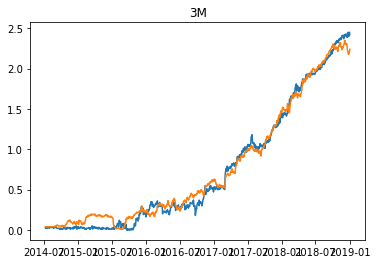

In [ ]:
y=Y_testT[0]

y_p=best_model.predict(np.array(stack(3,dfs_Test)))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('3M')
psave(y_p,'LSTMM3M')

2Y

In [ ]:
d={'lstm1':[256,128,64,32],'lstm2':[256,128,64,32],'dense':[256,128,64,32],'epoch':[100,300,500]}
n_input=3
output,best_model,best_para=gridsearch(dfs_Train,Y_trainT[1],n_input,d,LSTMM,split=3)
print(output,best_model,best_para)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0026
ave_score: 4.214429878474523
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0146
ave_score: 0.08937902220835288
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.3127
ave_score: 0.3126862645149231
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 3ms/step - loss: 12.5948
ave_score: 12.594797134399414
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.0047
ave_score: 0.07710221006224553
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.2916
ave_score: 0.291642427444458
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0036
ave_score: 0.06907766583996515
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.3089
ave_score: 0.30892

In [ ]:
error1=best_model.evaluate(np.array(stack(3,dfs_Test)),Y_testT[1])
print(error1)

36/36 [==============================] - 0s 2ms/step - loss: 0.0138


0.013813541270792484

Text(0.5, 1.0, '2Y')

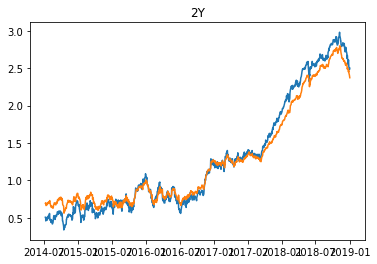

In [ ]:
y=Y_testT[1]

y_p=best_model.predict(np.array(stack(3,dfs_Test)))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('2Y')

In [ ]:
psave(y_p,'LSTMM2Y')

5Y

In [ ]:
d={'lstm1':[256,128,64,32],'lstm2':[256,128,64,32],'dense':[256,128,64,32],'epoch':[100,300,500]}
n_input=3
output,best_model,best_para=gridsearch(dfs_Train,Y_trainT[2],n_input,d,LSTMM,split=3)
print(output,best_model,best_para)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0102
ave_score: 0.045388467299441494
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.1668
ave_score: 0.1129913218319416
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.0786
ave_score: 0.0932132713496685
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 3ms/step - loss: 14.2148
ave_score: 14.214774131774902
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 14.2107
ave_score: 14.210655212402344
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.1230
ave_score: 0.10995595157146454
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 0.0033
ave_score: 0.04047098406590521
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 3ms/step - loss: 2.6404
ave_score: 1.3

In [ ]:
error2=best_model.evaluate(np.array(stack(3,dfs_Test)),Y_testT[2])
print(error2)

36/36 [==============================] - 0s 2ms/step - loss: 0.0039


0.003949812613427639

Text(0.5, 1.0, '5Y')

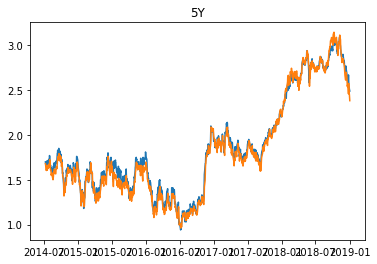

In [ ]:
y=Y_testT[2]

y_p=best_model.predict(np.array(stack(3,dfs_Test)))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('5Y')

In [ ]:
psave(y_p,'LSTMM5Y')

10Y

In [ ]:
d={'lstm1':[256,128,64,32],'lstm2':[256,128,64,32],'dense':[256,128,64,32],'epoch':[100,300,500]}
n_input=3
output,best_model,best_para=gridsearch(dfs_Train,Y_trainT[3],n_input,d,LSTMM,split=3)
print(output,best_model,best_para)

number of combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 3ms/step - loss: 0.0071
ave_score: 0.04006317863240838
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.1214
ave_score: 0.12139984965324402
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 2ms/step - loss: 0.0909
ave_score: 0.061018780805170536
2 done
(32, 32, 128, 100)
21/21 [==============================] - 1s 2ms/step - loss: 0.0054
ave_score: 0.03755122050642967
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 2ms/step - loss: 0.0548
ave_score: 0.07212778925895691
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 3ms/step - loss: 17.3912
ave_score: 17.391206741333008
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 2ms/step - loss: 17.3871
ave_score: 17.387142181396484
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 2ms/step - loss: 4.4800
ave_score: 1

In [ ]:
error3=best_model.evaluate(np.array(stack(3,dfs_Test)),Y_testT[3])
print(error3)

36/36 [==============================] - 0s 2ms/step - loss: 0.0081
0.008141990751028061


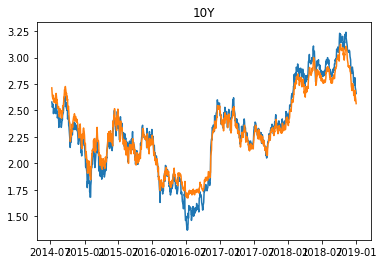

In [ ]:
y=Y_testT[3]

y_p=best_model.predict(np.array(stack(3,dfs_Test)))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('10Y')
psave(y_p,'LSTMM10Y')

30Y

In [ ]:
d={'lstm1':[256,128,64,32],'lstm2':[256,128,64,32],'dense':[256,128,64,32],'epoch':[100,300,500]}
n_input=3
output,best_model,best_para=gridsearch(dfs_Train,Y_trainT[4],n_input,d,LSTMM,split=3)
print(output,best_model,best_para)

combination: 192
(32, 32, 256, 100)
21/21 [==============================] - 0s 3ms/step - loss: 10.6803
ave_score: 3.6129081544155874
0 done
(32, 32, 256, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.0278
ave_score: 3.279510178292791
1 done
(32, 32, 256, 500)
21/21 [==============================] - 0s 3ms/step - loss: 0.0442
ave_score: 0.05248979479074478
2 done
(32, 32, 128, 100)
21/21 [==============================] - 0s 3ms/step - loss: 20.5290
ave_score: 20.528955459594727
3 done
(32, 32, 128, 300)
21/21 [==============================] - 0s 3ms/step - loss: 0.1649
ave_score: 0.16485950350761414
4 done
(32, 32, 128, 500)
21/21 [==============================] - 0s 4ms/step - loss: 0.0568
ave_score: 0.08723733760416508
5 done
(32, 32, 64, 100)
21/21 [==============================] - 0s 3ms/step - loss: 17.7273
ave_score: 8.911345139145851
6 done
(32, 32, 64, 300)
21/21 [==============================] - 0s 4ms/step - loss: 0.0087
ave_score: 0.0459799328818

In [ ]:
error4=best_model.evaluate(np.array(stack(3,dfs_Test)),Y_testT[4])
print(error4)

36/36 [==============================] - 0s 3ms/step - loss: 0.0104


0.010352153331041336

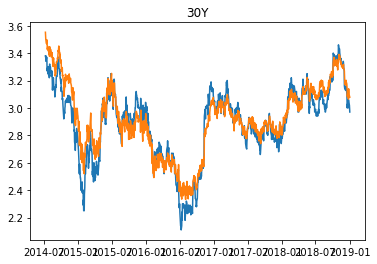

In [ ]:
y=Y_testT[4]

y_p=best_model.predict(np.array(stack(3,dfs_Test)))
plt.plot(X_testO.index,y)
plt.plot(X_testO.index,y_p)
plt.title('30Y')
psave(y_p,'LSTMM30Y')

In [ ]:
### copy&paste from previous results as each target was runned separately at the same time to finish more quickly
error4=0.010352153331041336
error3=0.008141990751028061
error2=0.003949812613427639
error1=0.013813541270792484
error0=0.007204554975032806

In [ ]:
e=[error0,error1,error2,error3,error4]

In [ ]:
psave(e,'LSTMERROR')